# Kalman Spread Parameter in Trading

In [4]:
# 0. Imports & I/O ------------------------------------------------------
!pip install polars pykalman
import polars as pl
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pykalman]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pykalman]


In [6]:
df = pl.read_parquet("../data/processed/ZNZF_1m.parquet") \
       .sort("ts_event") \
       .with_columns(pl.col("ts_event").alias("dt"))  # easier alias

In [7]:
kf = KalmanFilter(
    transition_matrices      = np.eye(2),
    observation_matrices     = np.array([[df['ZF'][0], 1.0]]),
    transition_covariance    = np.eye(2) * 1e-4,
    observation_covariance   = np.array([[1e-2]]),
    initial_state_mean       = [1.0, 0.0],
    initial_state_covariance = np.eye(2)
)

state = [kf.initial_state_mean]

In [8]:
for a, b in zip(df['ZN'][1:], df['ZF'][1:]):
    H = np.array([[b, 1.0]])
    x_prev = state[-1]
    K = (kf.transition_covariance*2) @ H.T @ \
        np.linalg.inv(H @ (kf.transition_covariance*2) @ H.T + kf.observation_covariance)
    x_new = x_prev + K[:, 0] * (a - H @ x_prev)
    state.append(x_new)

state = np.vstack(state)
df = df.with_columns([
        pl.Series("beta",  state[:,0]),
        pl.Series("alpha", state[:,1]),
        pl.Series("spread", df['ZN'] - state[:,0]*df['ZF'] - state[:,1])
     ])

In [ ]:
k = 0.01
mu, var, z = 0.0, 1.0, []
for s in df['spread']:
    mu  = (1-k)*mu  + k*s
    var = (1-k)*var + k*(s-mu)**2
    z.append((s - mu) / np.sqrt(var + 1e-9))
df = df.with_columns(pl.Series("z", z))

In [11]:
ENTRY, EXIT, STOP = 2.0, 0.3, 5.0
pos, pnl = 0, [0]

for i in range(1, df.height):
    z_now = df['z'][i]

    if pos and (abs(z_now) < EXIT or abs(z_now) > STOP):
        pos = 0
    elif pos == 0 and abs(z_now) > ENTRY:
        pos = -np.sign(z_now)

    pnl.append(pnl[-1] + pos * (df['spread'][i] - df['spread'][i-1]))

df = df.with_columns(
    pl.Series("pos", [0]+[pos]*(df.height-1)),
    pl.Series("pnl", pnl, dtype=pl.Float64)
)


Strategy Sharpe (no costs): -7.29


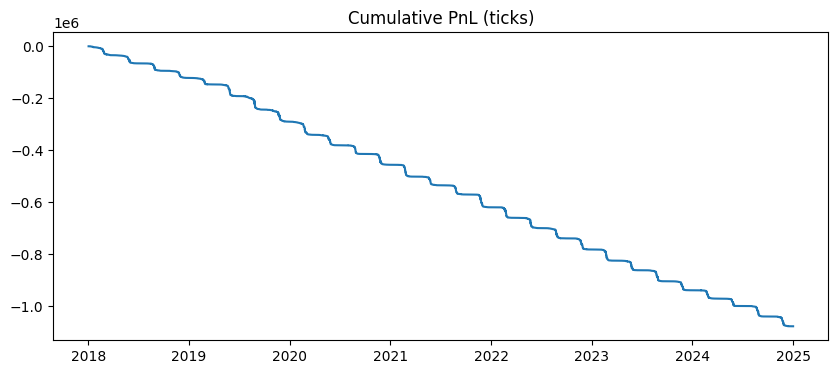

In [12]:
# 4. Quick performance view ---------------------------------------------
ret = np.diff(pnl)
sharpe = np.mean(ret)/np.std(ret) * np.sqrt(252*6.5*12)
print("Strategy Sharpe (no costs):", round(sharpe,2))

plt.figure(figsize=(10,4))
plt.plot(df['dt'], df['pnl'])
plt.title("Cumulative PnL (ticks)")
plt.show()